### Import statements 

In [0]:
import nltk
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.collocations import *
import pandas as pd
import numpy as np
import re
import datetime
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Loading dataset

In [0]:
category_values = ['alt.atheism', 'talk.religion.misc',
                'comp.graphics', 'sci.space']
news_dataset = fetch_20newsgroups(subset='all', categories=category_values, remove=["headers", "footers", "quotes"], random_state=42, shuffle=True)

# Printing target names
news_dataset.target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

In [0]:
# Printing a sample from the dataset 
news_dataset.data[0]

"My point is that you set up your views as the only way to believe.  Saying \nthat all eveil in this world is caused by atheism is ridiculous and \ncounterproductive to dialogue in this newsgroups.  I see in your posts a \nspirit of condemnation of the atheists in this newsgroup bacause they don'\nt believe exactly as you do.  If you're here to try to convert the atheists \nhere, you're failing miserably.  Who wants to be in position of constantly \ndefending themselves agaist insulting attacks, like you seem to like to do?!\nI'm sorry you're so blind that you didn't get the messgae in the quote, \neveryone else has seemed to."

## 1)a) Tokenization


### Tokens with POS tagging and retaining the paragraph-level structure

In [0]:
tokenized_data = [word_tokenize(each_record) for each_record in news_dataset.data]
tokens_with_pos = [nltk.pos_tag(tokens) for tokens in tokenized_data]

## Bigram collocations


### Tokenizing the whole corpus to find bigrams across the corpus

In [0]:
# Using the already tokenized words along with their POS tags and making them 1D to feed it into bigram collocations
tokens_with_pos_tags = [each_tuple for each_record in tokens_with_pos for each_tuple in each_record]
tokens_with_pos_tags

[('My', 'PRP$'),
 ('point', 'NN'),
 ('is', 'VBZ'),
 ('that', 'IN'),
 ('you', 'PRP'),
 ('set', 'VBP'),
 ('up', 'RP'),
 ('your', 'PRP$'),
 ('views', 'NNS'),
 ('as', 'IN'),
 ('the', 'DT'),
 ('only', 'JJ'),
 ('way', 'NN'),
 ('to', 'TO'),
 ('believe', 'VB'),
 ('.', '.'),
 ('Saying', 'VBG'),
 ('that', 'IN'),
 ('all', 'DT'),
 ('eveil', 'NN'),
 ('in', 'IN'),
 ('this', 'DT'),
 ('world', 'NN'),
 ('is', 'VBZ'),
 ('caused', 'VBN'),
 ('by', 'IN'),
 ('atheism', 'NN'),
 ('is', 'VBZ'),
 ('ridiculous', 'JJ'),
 ('and', 'CC'),
 ('counterproductive', 'JJ'),
 ('to', 'TO'),
 ('dialogue', 'VB'),
 ('in', 'IN'),
 ('this', 'DT'),
 ('newsgroups', 'NN'),
 ('.', '.'),
 ('I', 'PRP'),
 ('see', 'VBP'),
 ('in', 'IN'),
 ('your', 'PRP$'),
 ('posts', 'NNS'),
 ('a', 'DT'),
 ('spirit', 'NN'),
 ('of', 'IN'),
 ('condemnation', 'NN'),
 ('of', 'IN'),
 ('the', 'DT'),
 ('atheists', 'NNS'),
 ('in', 'IN'),
 ('this', 'DT'),
 ('newsgroup', 'NN'),
 ('bacause', 'IN'),
 ('they', 'PRP'),
 ("don'", 'VBP'),
 ('t', 'JJ'),
 ('believe', 'VBP

### Extraction of Bigram Collocations from the tokenized corpus (with POS tags)

In [0]:
# Creating a bigram collocation extractor object
bigram_extractor = BigramCollocationFinder.from_words(tokens_with_pos_tags)

In [0]:
bigram_extractor

In [0]:
# Printing the bigrams
bigram_freq_list = list(bigram_extractor.ngram_fd.items())
bigram_freq_df = pd.DataFrame(bigram_freq_list, columns=['bigram', 'frequency']).sort_values(by='frequency', ascending=False)

print(bigram_freq_df)

                                      bigram  frequency
1825                      ((--, :), (--, :))       9878
45                     ((of, IN), (the, DT))       3974
322                      ((,, ,), (and, CC))       3569
264                      ((., .), (The, DT))       2569
35                        ((., .), (I, PRP))       2358
110                    ((in, IN), (the, DT))       2232
140                      ((,, ,), (but, CC))       1814
3212                        ((), )), (., .))       1528
526                      ((,, ,), (the, DT))       1396
541                    ((to, TO), (the, DT))       1391
1478                      ((,, ,), (I, PRP))       1270
2672                     ((., .), (It, PRP))       1193
77                      ((to, TO), (be, VB))       1145
855                    ((on, IN), (the, DT))       1105
1774                  ((do, VBP), (n't, RB))       1104
864                     ((is, VBZ), (a, DT))       1035
139                         ((), )), (,, ,))    

## 1)b) Applying Frequency with Filter technique

We can see that the dataframe displayed above contains many stopwords, operators and punctuations in the bigram collocations. Firstly we could apply a filter to remove the bigrams that contain stopwords, punctuation marks and operators. We would also apply another filter which retains bigrams that contains the following two combinations of POS tags:

- ADJ (adjective), NN (noun)
- NN, NN

### The reason for applying the POS tag filter is because in literature, these two POS tags are the most commonly used ones in literature.

### STOPWORD AND OPERATORS FILTER

In [0]:
# Adding the stopwords in a list
stopwords_list = stopwords.words('english')
# Operator and punctuations regex condition
op_punc_omitter = re.compile(r'\w+')

In [0]:
# Anonymous function to remove bigrams containing stopwords
stopword_filter_f1 = lambda x: (x[0][0][0].lower() not in stopwords_list) and (x[0][1][0].lower() not in stopwords_list) and (op_punc_omitter.match(x[0][0][0])) and (op_punc_omitter.match(x[0][1][0]))


In [0]:
# Applying the stopword filter to list
f1_bigram_freq_list = list(filter(stopword_filter_f1, bigram_freq_list))
# Conversion to df
f1_bigram_freq_df = pd.DataFrame(f1_bigram_freq_list, columns=['bigram', 'frequency']).sort_values(by='frequency', ascending=False)
f1_bigram_freq_df.shape

(93448, 2)

### Inference: After applying the stopword filter, we can see that the number of bigrams in the dataframe has reduced by ~285000

### POS TAG FILTER

In [0]:
# Noun list 
noun_abbr = ['NN', 'NNS', 'NNP', 'NNPS']

# Adjective list
adj_abbr = ['JJ', 'JJR', 'JJS']

# Anonymous function to remove bigrams containing pos tags other than Noun or Adj phrases in the first word 
# and just Noun phrases in the second word
pos_tag_filter_f2 = lambda x: (x[0][0][1] in noun_abbr or x[0][0][1] in adj_abbr) and (x[0][1][1] in noun_abbr)

In [0]:
# Applying the pos tag filter
f1f2_bigrams_list = list(filter(pos_tag_filter_f2, f1_bigram_freq_list))
# Conversion to dataframe
f2_bigram_freq_df = pd.DataFrame(f1f2_bigrams_list, columns=['bigram', 'frequency']).sort_values(by='frequency', ascending=False)
f2_bigram_freq_df.shape

(45412, 2)

### Inference: After applying the POS tag filter, we can see that the number of bigrams has reduced even more by ~57000

### Printing the top 20 results of Frequency with filter technique

In [0]:
f2_bigram_freq_df.head(20)

,bigram,frequency
1220,"((image, NN), (processing, NN))",82
1085,"((source, NN), (code, NN))",68
822,"((New, NNP), (York, NNP))",62
1985,"((Jesus, NNP), (Christ, NNP))",62
1282,"((anonymous, JJ), (FTP, NNP))",60
1932,"((many, JJ), (people, NNS))",59
884,"((solar, JJ), (system, NN))",57
2883,"((space, NN), (station, NN))",55
13889,"((image, NN), (quality, NN))",55
12273,"((physical, JJ), (universe, NN))",54


## 1)b) Pointwise Mutual Information (PMI) filter

In [0]:
# Calculating Pointwise mutual information for bigrams
bigram_assoc = nltk.collocations.BigramAssocMeasures()
bigram_extractor.apply_freq_filter(20)
bigram_pmi_list = list(bigram_extractor.score_ngrams(bigram_assoc.pmi))

In [0]:
# Conversion to df
bigram_pmi_df = pd.DataFrame(bigram_pmi_list, columns=['bigram', 'Pmi']).sort_values(by='Pmi', ascending=False)

### Printing the top 20 results of PMI Technique

In [0]:
bigram_pmi_df.head(20)

,bigram,Pmi
0,"((Beauchaine, NNP), (bobbe, NN))",14.832734
1,"((sank, VBD), (Manhattan, NNP))",14.832734
2,"((MY, NNP), (REPLY, NNP))",14.741760
3,"((GENERAL, NNP), (UNIFIED, NNP))",14.691134
4,"((61, CD), (275, CD))",14.478726
5,"((Physicist, NNP), (Dewey, NNP))",14.471773
6,"((Dewey, NNP), (B., NNP))",14.210530
7,"((Air, NNP), (Force, NNP))",14.194272
8,"((Resource, NNP), (Listing, NNP))",14.004795
9,"((comprehensive, JJ), (GENERAL, NNP))",13.921914


### 1) b) T-test


In [0]:
# Performing T-test on bigrams
bigram_ttest_list =list(bigram_extractor.score_ngrams(bigram_assoc.student_t))
len(bigram_ttest_list)

3736

In [0]:
# Applying the stopword and punctuation filter to list
bigram_ttest_f1_list = list(filter(stopword_filter_f1, bigram_ttest_list))

# Conversion to df
f1_bigram_ttest_df = pd.DataFrame(bigram_ttest_f1_list, columns=['bigram', 'T_Value']).sort_values(by='T_Value', ascending=False)
f1_bigram_ttest_df.shape

(141, 2)

### Inference -  After removing the stopwords and punctuations, we can see that the number of bigrams has reduced by ~290000

In [0]:
# Applying the pos tag filter
bigram_ttest_f1f2_list = list(filter(pos_tag_filter_f2, bigram_ttest_f1_list))

# Conversion to df
f1f2_bigram_ttest_df = pd.DataFrame(bigram_ttest_f1f2_list, columns=['bigram', 'T_Value']).sort_values(by='T_Value', ascending=False)
f1f2_bigram_ttest_df.shape

(83, 2)

### Inference -  After applying POS filters,  we can see that the number of bigrams has been reduced even more by ~57000

In [0]:
f1f2_bigram_ttest_df.head(20)

,bigram,T_Value
0,"((image, NN), (processing, NN))",9.035436
1,"((source, NN), (code, NN))",8.236531
2,"((New, NNP), (York, NNP))",7.872193
3,"((Jesus, NNP), (Christ, NNP))",7.855769
4,"((anonymous, JJ), (FTP, NNP))",7.741319
5,"((many, JJ), (people, NNS))",7.551466
6,"((solar, JJ), (system, NN))",7.533181
7,"((space, NN), (station, NN))",7.404434
8,"((image, NN), (quality, NN))",7.385288
9,"((physical, JJ), (universe, NN))",7.345248


### 1) b) Chi-sq Test 

In [0]:
# Apply Chi-sq Test on bigrams
bigram_chisq_list = list(bigram_extractor.score_ngrams(bigram_assoc.chi_sq))
len(bigram_chisq_list)

3736

In [0]:
# Conversion to df
bigram_chisq_df = pd.DataFrame(bigram_chisq_list, columns=['bigram', 'Chi-sq']).sort_values(by='Chi-sq', ascending=False)
bigram_chisq_df.shape

(3736, 2)

In [0]:
bigram_chisq_df.head(20)

,bigram,Chi-sq
0,"((GENERAL, NNP), (UNIFIED, NNP))",740676.211396
1,"((Beauchaine, NNP), (bobbe, NN))",700336.473261
2,"((sank, VBD), (Manhattan, NNP))",700336.473261
3,"((MY, NNP), (REPLY, NNP))",602740.599843
4,"((Dewey, NNP), (B., NNP))",587693.178963
5,"((--, :), (--, :))",548069.418088
6,"((United, NNP), (States, NNPS))",543905.734319
7,"((Physicist, NNP), (Dewey, NNP))",522586.289388
8,"((Air, NNP), (Force, NNP))",487376.613634
9,"((61, CD), (275, CD))",456616.110843


In [0]:
overlap_df = pd.DataFrame([f2_bigram_freq_df[:20].bigram.values, bigram_pmi_df[:20].bigram.values, f1f2_bigram_ttest_df[:20].bigram.values, bigram_chisq_df[:20].bigram.values]).T
overlap_df.columns=["Freq with filter", "PMI", "t-test", "chi-squared"]

In [0]:
overlap_df

,Freq with filter,PMI,t-test,chi-squared
0,"((image, NN), (processing, NN))","((Beauchaine, NNP), (bobbe, NN))","((image, NN), (processing, NN))","((GENERAL, NNP), (UNIFIED, NNP))"
1,"((source, NN), (code, NN))","((sank, VBD), (Manhattan, NNP))","((source, NN), (code, NN))","((Beauchaine, NNP), (bobbe, NN))"
2,"((New, NNP), (York, NNP))","((MY, NNP), (REPLY, NNP))","((New, NNP), (York, NNP))","((sank, VBD), (Manhattan, NNP))"
3,"((Jesus, NNP), (Christ, NNP))","((GENERAL, NNP), (UNIFIED, NNP))","((Jesus, NNP), (Christ, NNP))","((MY, NNP), (REPLY, NNP))"
4,"((anonymous, JJ), (FTP, NNP))","((61, CD), (275, CD))","((anonymous, JJ), (FTP, NNP))","((Dewey, NNP), (B., NNP))"
5,"((many, JJ), (people, NNS))","((Physicist, NNP), (Dewey, NNP))","((many, JJ), (people, NNS))","((--, :), (--, :))"
6,"((solar, JJ), (system, NN))","((Dewey, NNP), (B., NNP))","((solar, JJ), (system, NN))","((United, NNP), (States, NNPS))"
7,"((space, NN), (station, NN))","((Air, NNP), (Force, NNP))","((space, NN), (station, NN))","((Physicist, NNP), (Dewey, NNP))"
8,"((image, NN), (quality, NN))","((Resource, NNP), (Listing, NNP))","((image, NN), (quality, NN))","((Air, NNP), (Force, NNP))"
9,"((physical, JJ), (universe, NN))","((comprehensive, JJ), (GENERAL, NNP))","((physical, JJ), (universe, NN))","((61, CD), (275, CD))"


## 1)c) 

### There is overlap between techniques like frequency with filter and t-test while the results are somewhat similar in PMI and chi-squared test. PMI and chi-squared test did not require filters and both of them produced credible results even without them. The degree of overlap between frequency with filter and t-test is very high and this is due to both these techniques giving significance to bigrams with higher frequency. This has also been influenced due to filtering of certain pos tags along with removing the stop words. Whereas in PMI, the bigrams that occur less frequently have much significance and thus it doesn't overlap with the other two techniques.

### It does make sense to take union of the bigrams as it gives an overall idea about the important bigrams extracted using various techniques. There is variation in each technique and all of these variations can be covered by taking the union of results. For example, a technique like PMI gives importance to less frequent bigrams whereas a technique like frequency with filter is based on bigrams that occur more often. So, taking an union will help us cover all bases.

## 2)a) Data Cleaning

In [0]:
# Converting 4D to 2D
unclean_tokens = tokenized_data

### Cleaning stopwords

In [0]:
# Compiling a regex pattern out of stopwords
stopwords_pattern = re.compile(r'\b({})\b'.format("|".join(stopwords_list)), re.I)

### Function to remove stopwords

In [0]:
# Substitute stopwords with ''
sub_stop_words = lambda x: stopwords_pattern.sub('', x)

In [0]:
clean_stopwords = lambda unclean_tokens: [list(filter(lambda x:x,list(map(sub_stop_words, each_record)))) for each_record in unclean_tokens]

In [0]:
unclean_tokens = clean_stopwords(unclean_tokens)

### Cleaning numbers and non-alphabet letters

In [0]:
# Compiling a regex pattern to detect anything other than non-alphabets
non_alpha_pattern = re.compile(r'[^a-zA-Z\s]')

### Function to remove non alphabets and numbers

In [0]:
# Substitute non alphabets with ''
sub_non_alphabets = lambda x: non_alpha_pattern.sub('', x)

In [0]:
clean_non_alphabets = lambda unclean_tokens: [list(filter(lambda x:x,list(map(sub_non_alphabets, each_record)))) for each_record in unclean_tokens]

In [0]:
unclean_tokens = clean_non_alphabets(unclean_tokens)

### Stemming of words

In [0]:
# Creating object for stemmer
stemmer = PorterStemmer()

In [0]:
# Function to stem the words
stemmer_fn = lambda word: stemmer.stem(word)

In [0]:
stem_words = lambda unclean_tokens: [list(map(stemmer_fn, each_record)) for each_record in unclean_tokens]

In [0]:
clean_tokens = stem_words(unclean_tokens)

## 2)b) Conversion of the entire corpus into bag of words

In [0]:
# Converting 2D to 1D
clean_tokens = list(map(lambda x: " ".join(x), clean_tokens))

In [0]:
count_vectorizer = CountVectorizer()

# Creating a bag of words model
bag_of_words = count_vectorizer.fit_transform(clean_tokens)

# Converting to bag of words to array
counts = bag_of_words.toarray()

### Performing Tf-Idf operation

In [0]:
tfidf_transformer = TfidfTransformer()

# Creating a tf-idf model
tfidf_scores = tfidf_transformer.fit_transform(counts)
tfidf_scores.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## 2)c) Splitting data into train and test

In [0]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_scores, news_dataset.target, test_size=0.3)

In [0]:
print(f"Start time: {datetime.datetime.now()}")
# SVC
svc_parameters = {'gamma':['auto', 'scale'], 'kernel':['rbf','poly','linear']}
svc_gsc = GridSearchCV(estimator=SVC(), param_grid=svc_parameters,
                       scoring='r2', cv=8, n_jobs=-1)
grid_result = svc_gsc.fit(X_train, y_train)
svc_best_params = grid_result.best_params_
print(f"End time: {datetime.datetime.now()}")
svc_best_params

Start time: 2019-07-17 18:33:35.819736


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


End time: 2019-07-17 18:35:06.456047


{'gamma': 'auto', 'kernel': 'linear'}

### Using gridsearch, we have found the hyperparameters that suit the SVC. The kernel we have used initially is "linear"

### Training SVM classifier

In [0]:
svm_classifier = SVC(gamma="auto", kernel="linear")

In [0]:
# Training
svm_classifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
# Predictions
y_svm_pred = svm_classifier.predict(X_test)

### Classification report for SVC

In [0]:
print(classification_report(y_test, y_svm_pred))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72       226
           1       0.92      0.89      0.90       289
           2       0.80      0.91      0.85       312
           3       0.77      0.62      0.69       190

    accuracy                           0.81      1017
   macro avg       0.80      0.79      0.79      1017
weighted avg       0.81      0.81      0.81      1017



### Confusion matrix for SVC

In [0]:
cf = confusion_matrix(y_test, y_svm_pred)
cf

array([[163,   3,  29,  31],
       [  8, 256,  24,   1],
       [ 11,  12, 285,   4],
       [ 45,   7,  20, 118]])

### Heatmap for Confusion matrix

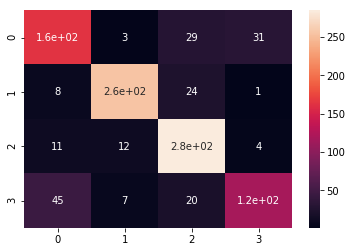

In [0]:
sns.heatmap(cf, annot=True)

### Training MultinomialNB classifier

In [0]:
print(f"Start time: {datetime.datetime.now()}")
# Random Forest Regressor
mnb_parameters = {'alpha':[0.1, 1], 'fit_prior':[True, False]}
mnb_gsc = GridSearchCV(estimator=MultinomialNB(), param_grid=mnb_parameters,
                       scoring='r2', cv=8, n_jobs=-1)
grid_result = mnb_gsc.fit(X_train, y_train)
mnb_best_params = grid_result.best_params_
print(f"End time: {datetime.datetime.now()}")
mnb_best_params

Start time: 2019-07-17 18:35:25.261219
End time: 2019-07-17 18:35:25.480070


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.1, 'fit_prior': True}

### Using gridsearch, we have determined the initial paramters for MultinomialNB as well.

In [0]:
mnb_classifier = MultinomialNB(alpha=0.1, fit_prior=True)

In [0]:
mnb_classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [0]:
y_mnb_preds = mnb_classifier.predict(X_test)

### Classification report for MultinomialNB

In [0]:
print(classification_report(y_test, y_mnb_preds))

              precision    recall  f1-score   support

           0       0.72      0.80      0.76       226
           1       0.84      0.93      0.89       289
           2       0.91      0.88      0.89       312
           3       0.81      0.62      0.70       190

    accuracy                           0.83      1017
   macro avg       0.82      0.81      0.81      1017
weighted avg       0.83      0.83      0.82      1017



### Confusion matrix for MultinomialNB

In [0]:
cf = confusion_matrix(y_test, y_mnb_preds)
cf

array([[181,  13,  12,  20],
       [  4, 270,  10,   5],
       [ 13,  24, 273,   2],
       [ 54,  13,   6, 117]])

### Heatmap for Confusion matrix

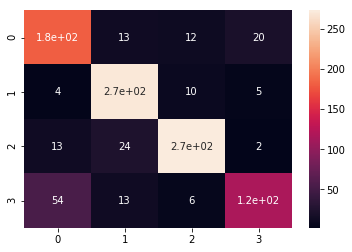

In [0]:
sns.heatmap(cf, annot=True)

### Changing kernel of SVC to rbf

In [0]:
svm_classifier = SVC(gamma='auto', kernel='rbf')

In [0]:
# Training
svm_classifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
# Predictions
y_svm_pred = svm_classifier.predict(X_test)

### Classification report for SVC

In [0]:
print(classification_report(y_test, y_svm_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       226
           1       0.28      1.00      0.44       289
           2       0.00      0.00      0.00       312
           3       0.00      0.00      0.00       190

    accuracy                           0.28      1017
   macro avg       0.07      0.25      0.11      1017
weighted avg       0.08      0.28      0.13      1017



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Confusion matrix for SVC after changing kernel to rbf

In [0]:
cf = confusion_matrix(y_test, y_svm_pred)
cf

array([[  0, 226,   0,   0],
       [  0, 289,   0,   0],
       [  0, 312,   0,   0],
       [  0, 190,   0,   0]])

### Heatmap for Confusion matrix

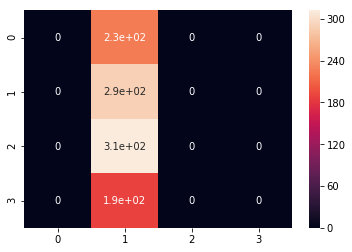

In [0]:
sns.heatmap(cf, annot=True)

### Which algo has higher accuracy and why?

### MultinomialNB has higher accuracy(83%) than SVM classifier because Naive Bayes has the tendency to handle sparse data problems well. The data with too many dimensions due to tf-idf has a lot of zeroes and the data is sparse. While in SVM classifier (81%), the linear kernel function gave decent accuracy while rbf(28%) didn't seem to suit this particular problem as the model's performance was too low.

### Changing the kernel of SVM and its effects: -> (A)

- The kernel function is generally used by linear classifiers to tailor to non-linear data by mapping them to higher dimensions. 
- In this case, changing the kernel function from linear to rbf produced inaccurate results.
- The linear kernel function worked really well because the data seems to be linearly separable. 
- The rbf kernel's complexity generally tends to increase with dimensions and the tfidf generally introduces a lot of dimensions because of the unique features across the corpus.
- Generally, if the number of features(dimensions) after applying Tfidf is already high, it is not necessary to map them to a higher dimensional space using rbf kernel function and the linear kernel is good enough. 
- Thus, as a result of changing the kernel to rbf function, the confusion between the classes increased and only a plenty of results were misclassified.

## 2)d) SVM classifier and MultinomailNB on data with nouns only

In [0]:
# Function to filter noun tags only
filter_nouns = lambda token: token[0] if token[1] in noun_abbr else ""

In [0]:
get_noun_tokens = lambda tokens: [list(filter(lambda x:x, list(map(filter_nouns, each_record)))) for each_record in tokens]

In [0]:
clean_tokens_nn = get_noun_tokens(tokens_with_pos)

### Data cleaning

In [0]:
# clean stopwords
clean_tokens_nn = clean_stopwords(clean_tokens_nn)
# clean numbers and non alphabets
clean_tokens_nn = clean_non_alphabets(clean_tokens_nn)
# stem words
clean_tokens_nn = stem_words(clean_tokens_nn)

In [0]:
# Converting 2D to 1D
clean_tokens_nn = list(map(lambda x: " ".join(x), clean_tokens_nn))

In [0]:
count_vectorizer_nn = CountVectorizer()

# Creating a bag of words model
bag_of_words = count_vectorizer_nn.fit_transform(clean_tokens_nn)

# Converting to bag of words to array
counts = bag_of_words.toarray()

### Performing Tf-Idf operation

In [0]:
tfidf_transformer = TfidfTransformer()

# Creating a tf-idf model
tfidf_scores = tfidf_transformer.fit_transform(counts)
tfidf_scores.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_scores, news_dataset.target, test_size=0.3)

### Training SVM Classifier

In [0]:
svm_classifier = SVC(gamma="auto", kernel="linear")

In [0]:
# Training
svm_classifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
# Predictions
y_svm_pred = svm_classifier.predict(X_test)

### Classification report for SVC

In [0]:
print(classification_report(y_test, y_svm_pred))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72       226
           1       0.92      0.89      0.90       289
           2       0.80      0.91      0.85       312
           3       0.77      0.62      0.69       190

    accuracy                           0.81      1017
   macro avg       0.80      0.79      0.79      1017
weighted avg       0.81      0.81      0.81      1017



### Confusion matrix for SVC

In [0]:
cf = confusion_matrix(y_test, y_svm_pred)
cf

array([[163,   3,  29,  31],
       [  8, 256,  24,   1],
       [ 11,  12, 285,   4],
       [ 45,   7,  20, 118]])

### Heatmap for Confusion matrix

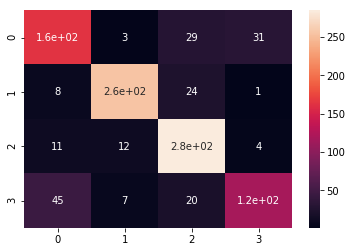

In [0]:
sns.heatmap(cf, annot=True)

### Training MultinomialNB classifier

In [0]:
mnb_classifier = MultinomialNB(alpha=0.1, fit_prior=True)

In [0]:
mnb_classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [0]:
y_mnb_preds = mnb_classifier.predict(X_test)

### Classification report for MultinomialNB

In [0]:
print(classification_report(y_test, y_mnb_preds))

              precision    recall  f1-score   support

           0       0.72      0.80      0.76       226
           1       0.84      0.93      0.89       289
           2       0.91      0.88      0.89       312
           3       0.81      0.62      0.70       190

    accuracy                           0.83      1017
   macro avg       0.82      0.81      0.81      1017
weighted avg       0.83      0.83      0.82      1017



### Confusion matrix for MultinomialNB

In [0]:
cf = confusion_matrix(y_test, y_mnb_preds)
cf

array([[181,  13,  12,  20],
       [  4, 270,  10,   5],
       [ 13,  24, 273,   2],
       [ 54,  13,   6, 117]])

### Heatmap for Confusion matrix

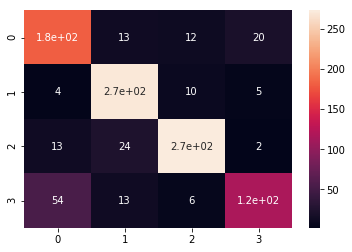

In [0]:
sns.heatmap(cf, annot=True)

### Changing kernel of SVC to rbf

In [0]:
svm_classifier = SVC(gamma="auto", kernel='rbf')

In [0]:
# Training
svm_classifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
# Predictions
y_svm_pred = svm_classifier.predict(X_test)

### Confusion matrix for SVC

In [0]:
cf = confusion_matrix(y_test, y_svm_pred)
cf

array([[  0, 226,   0,   0],
       [  0, 289,   0,   0],
       [  0, 312,   0,   0],
       [  0, 190,   0,   0]])

### Heatmap for Confusion matrix

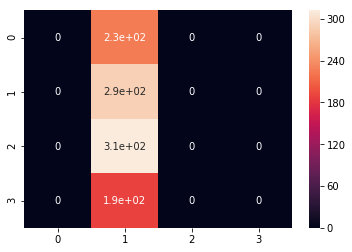

In [0]:
sns.heatmap(cf, annot=True)

### Accuracy of models on noun tokens and the whole corpus

### The accuracy of a linear kernel SVM(81%) and MultinomialNB(83%) on the noun tokens is not different from that of the accuracy on the whole corpus. It is the exact same. This indicates that most of the words with pos tags other than nouns can be eliminated from the corpus so as to reduce the dimensionality of data and the predictions will not get affected. It also reiterates the fact that nouns are a very important and distinguishing factor in text for classification.

### And, linear SVM classifier has way better accuracy than the rbf SVM classifier due to the same reasons listed above ((A) on the whole corpus). MultinomialNB performs better than the SVM classifier in general because as stated earlier, it tends to work better on sparse data well.

In [0]:
# size of vocabulary
print(f"Vocab with noun tokens: {len(count_vectorizer_nn.get_feature_names())}")
print(f"Vocab with all tokens: {len(count_vectorizer.get_feature_names())}")

Vocab with noun tokens: 18763
Vocab with all tokens: 24016


### Size of vocabulary

### The size of the vocabulary, as stated earlier, is lesser compared to the previous step where the whole corpus was used. This step greatly reduces the input features a.k.a dimensions of data. 